Diagnostics for NR

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/seob/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/seob/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
import glob

In [3]:
nr_waveforms = glob.glob("../data/ecc_waveforms/Non-Precessing/SXS/BBH_S*.h5")

In [21]:
waveform_path = nr_waveforms[0]
waveform_keywords = {"filepath": waveform_path,
                     "include_zero_ecc": True,
                    }
dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)

In [22]:
dataDict["params_dict"]

{'q': 9.997310743857062,
 'chi1': [6.566468331223331e-08,
  -2.072905545355622e-07,
  -1.0348597293911265e-06],
 'chi2': [1.4883213509646776e-10,
  4.877450073590725e-09,
  -1.9131149246896397e-06],
 'ecc': 9.8,
 'mean_ano': 0.0,
 'deltaTOverM': 0.09999999999854481,
 'Momega0': 0.005096886275990004}

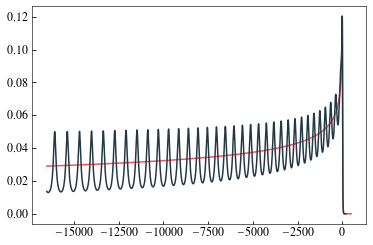

In [23]:
import numpy as np
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]))
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]))
# plt.xlim(dataDict["t"][0], )

Text(0.5, 1.0, 'q=10.0, ecc=9.80 method=ResidualAmplitude, BBH_SHK_q10_e05_D30_Res3.h5')

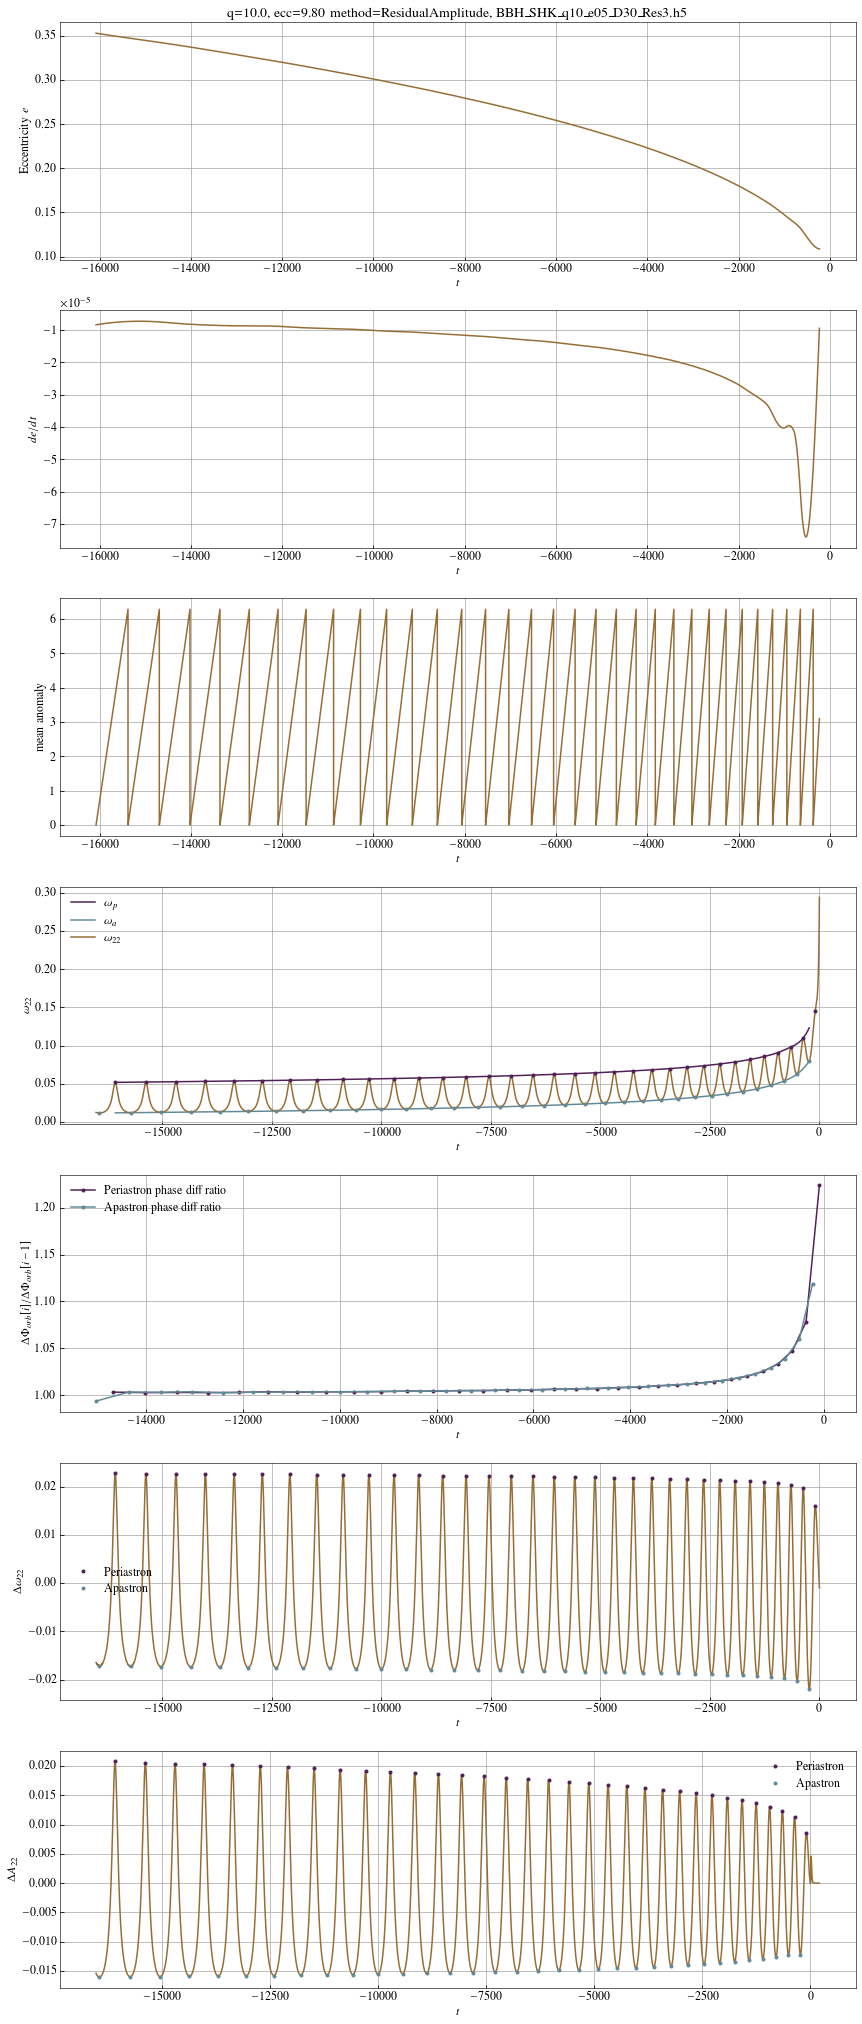

In [25]:
method = "ResidualAmplitude"
waveform_path = nr_waveforms[0]
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
w = waveform_path.split("/")[-1]
q = dataDict["params_dict"]["q"]
ecc = dataDict["params_dict"]["ecc"]
ax[0].set_title(f"q={q:.1f}, ecc={ecc:.2f} method={method}, {w}", fontsize=14)

### Diagnostic plots for Amplitude method

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:436: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


Text(0.5, 1.0, 'q=6.0, ecc=0.80 method=Amplitude, BBH_SHK_q6_e095_D65_Res3.h5')

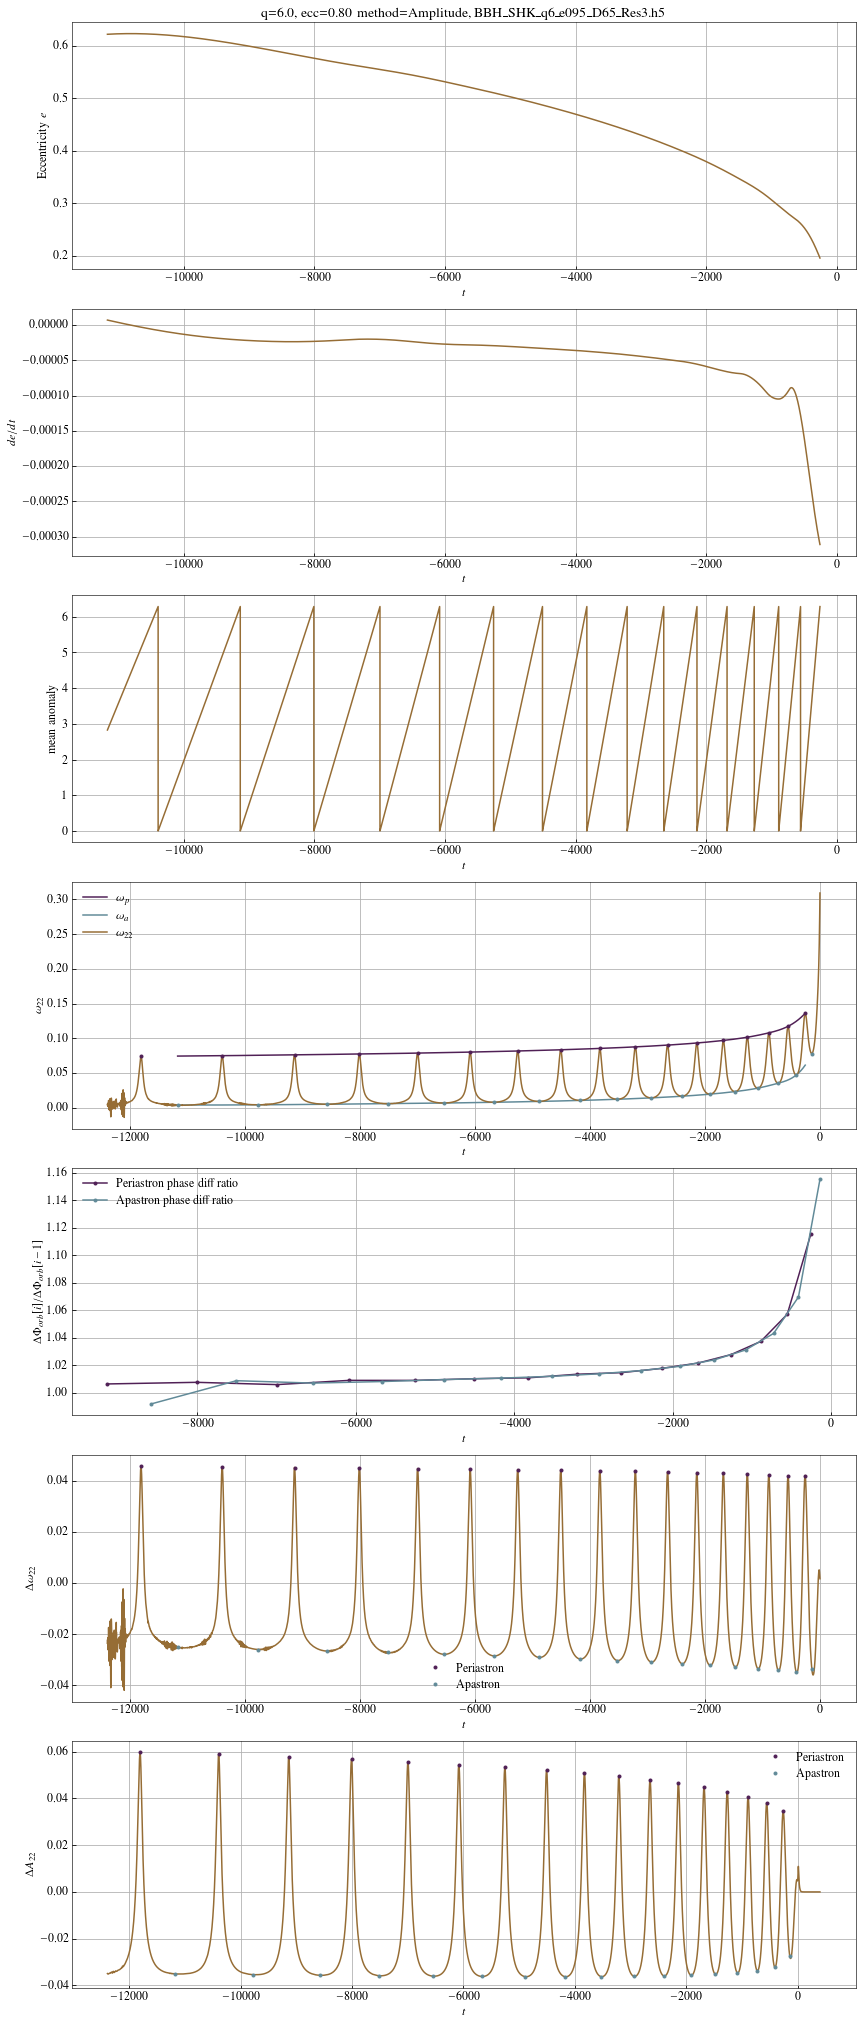

In [13]:
method = "Amplitude"
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
w = waveform_path.split("/")[-1]
q = dataDict["params_dict"]["q"]
ecc = dataDict["params_dict"]["ecc"]
ax[0].set_title(f"q={q:.1f}, ecc={ecc:.2f} method={method}, {w}", fontsize=14)

In [15]:
nr_waveforms[7]

'../data/ecc_waveforms/Non-Precessing/SXS/BBH_SHK_q6_e095_D65_Res3.h5'

In [16]:
waveform_keywords = {"filepath": '../data/ecc_waveforms/Non-Precessing/SXS/BBH_SHK_q6_e095_D65_Res3.h5'}
dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)

In [17]:
method = "FrequencyFits"
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
fig.suptitle(f"method={method}, {waveform_path}")

IndexError: index 5 is out of bounds for axis 0 with size 5

---------------------------------------------------------------------
---------------------------------------------------------------------


/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:436: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


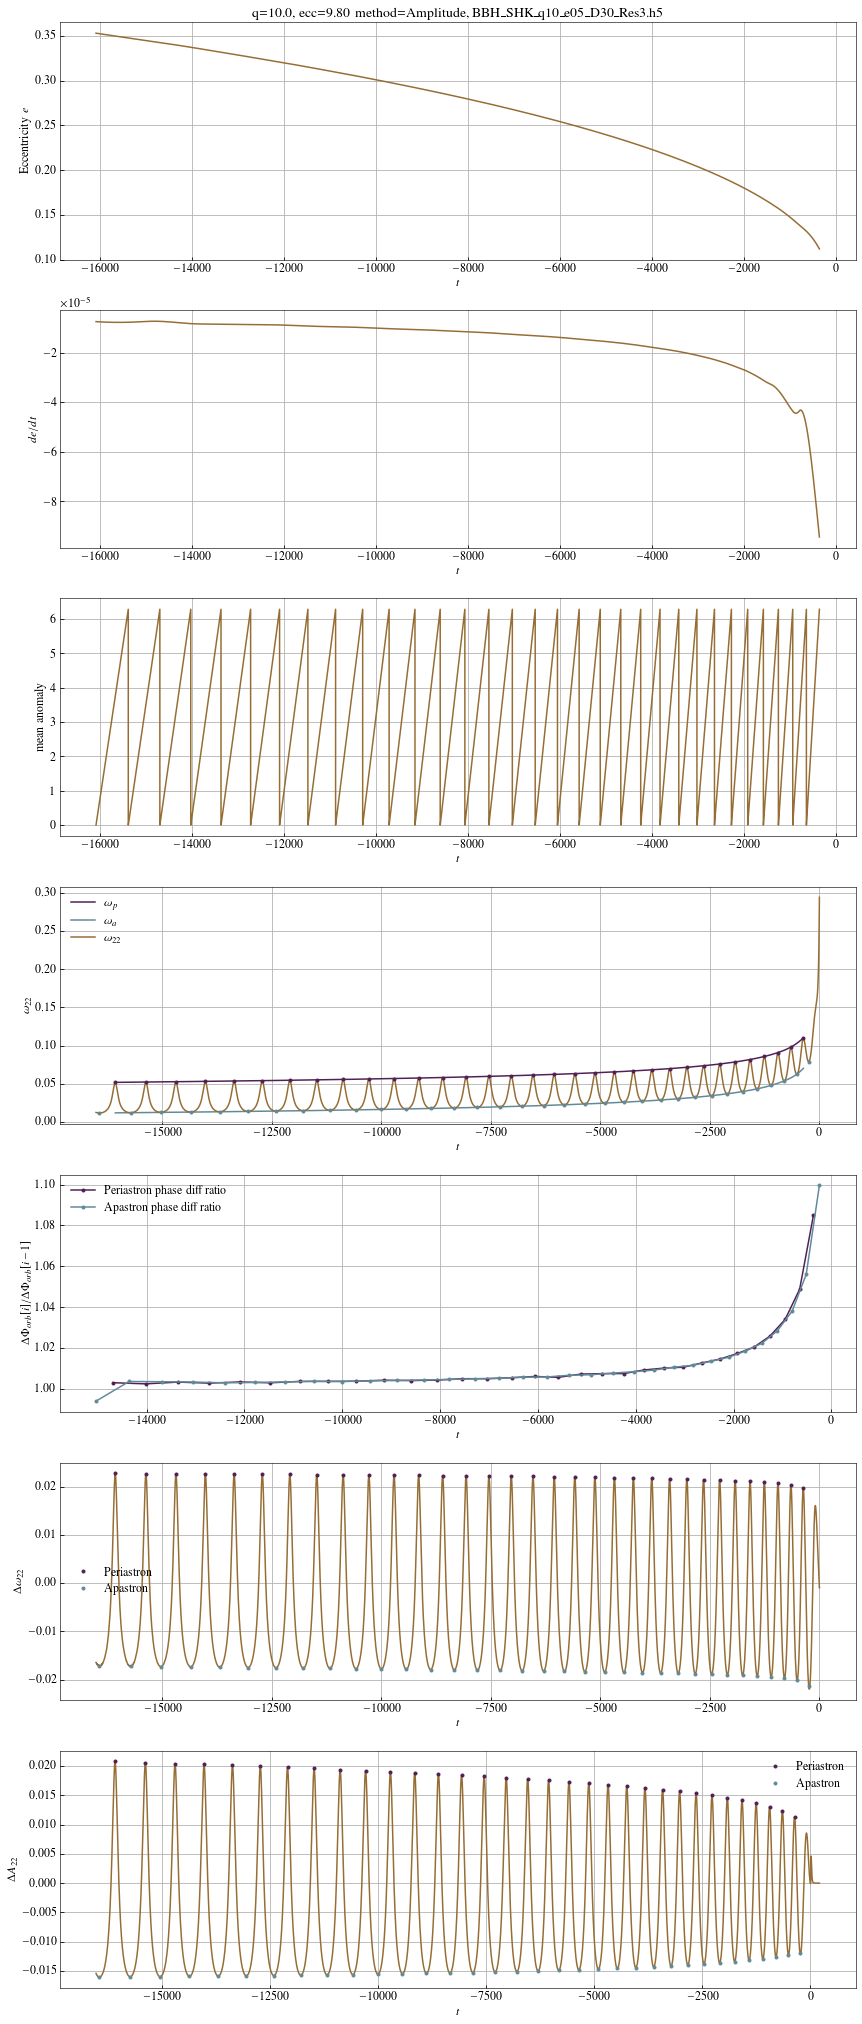

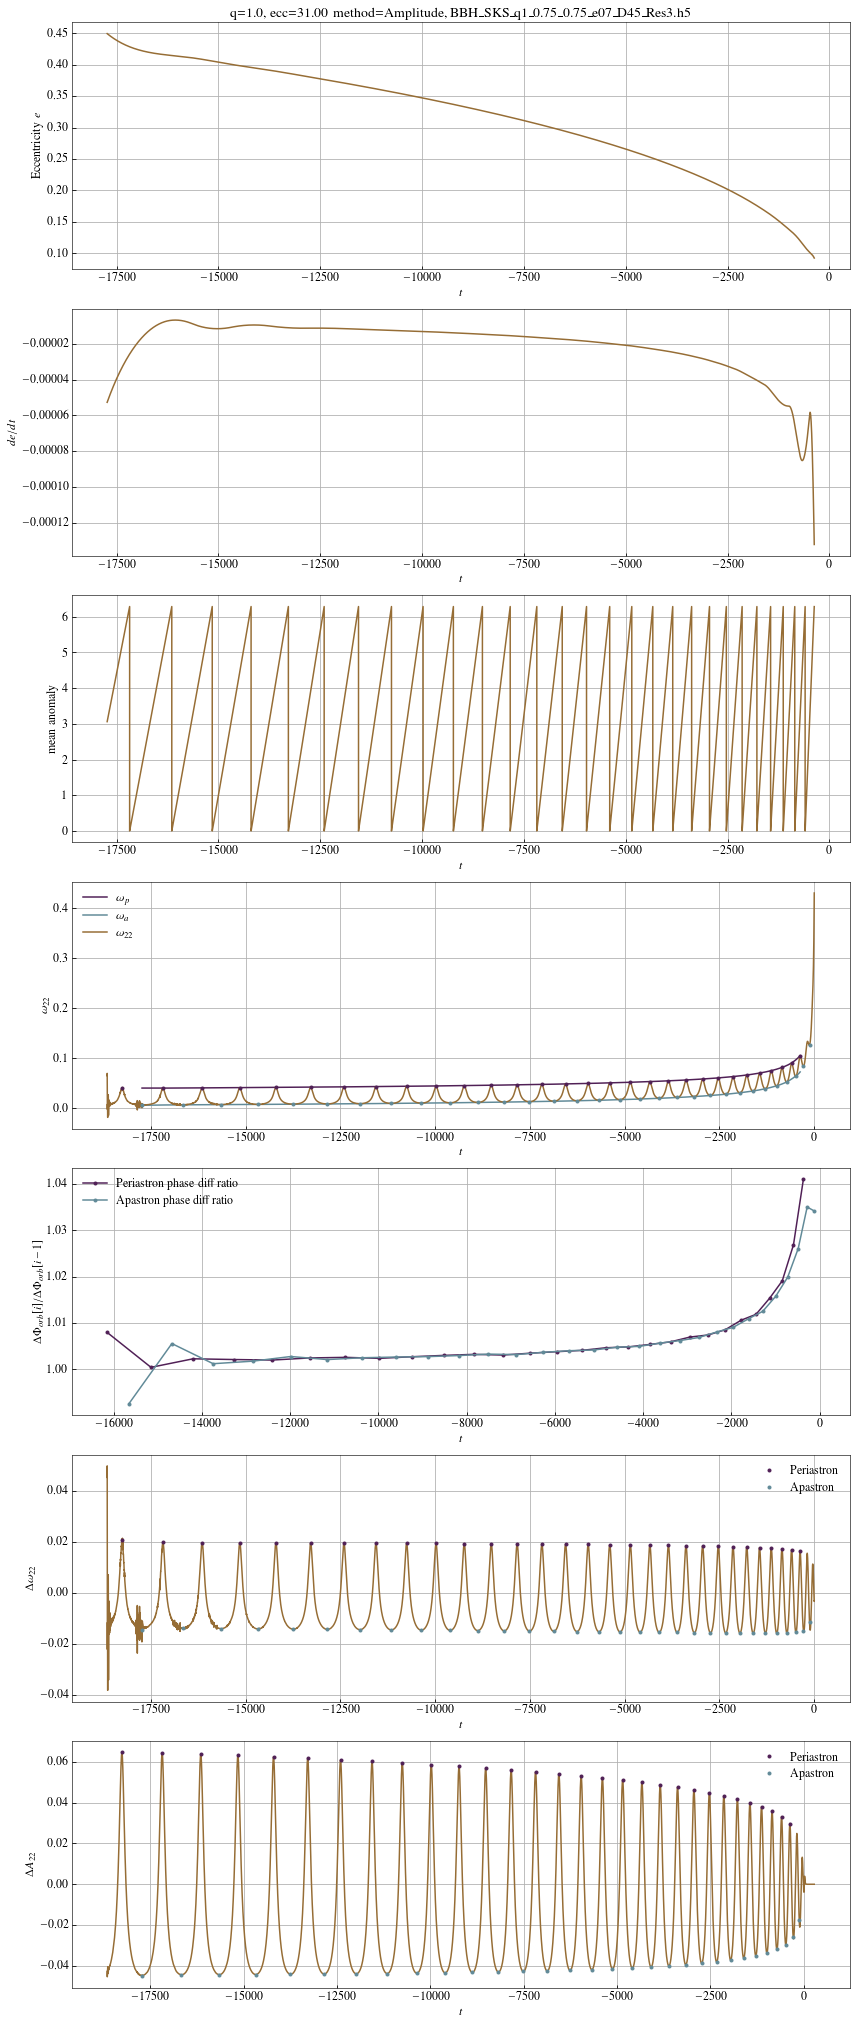

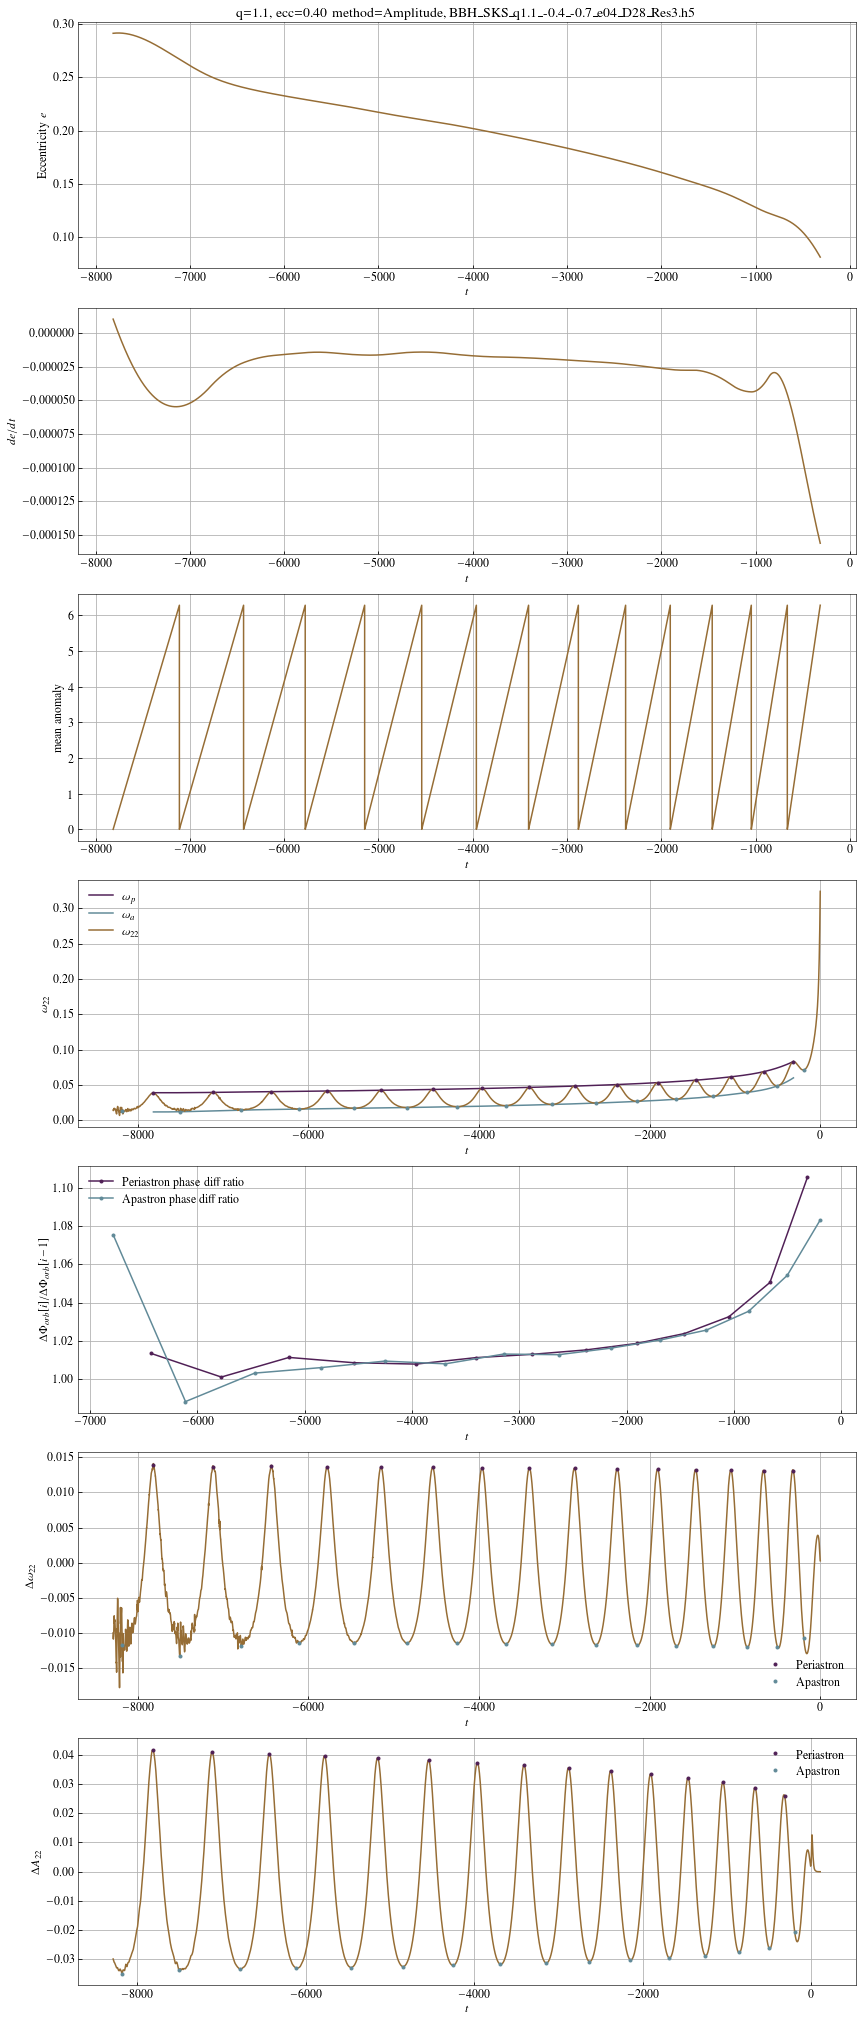

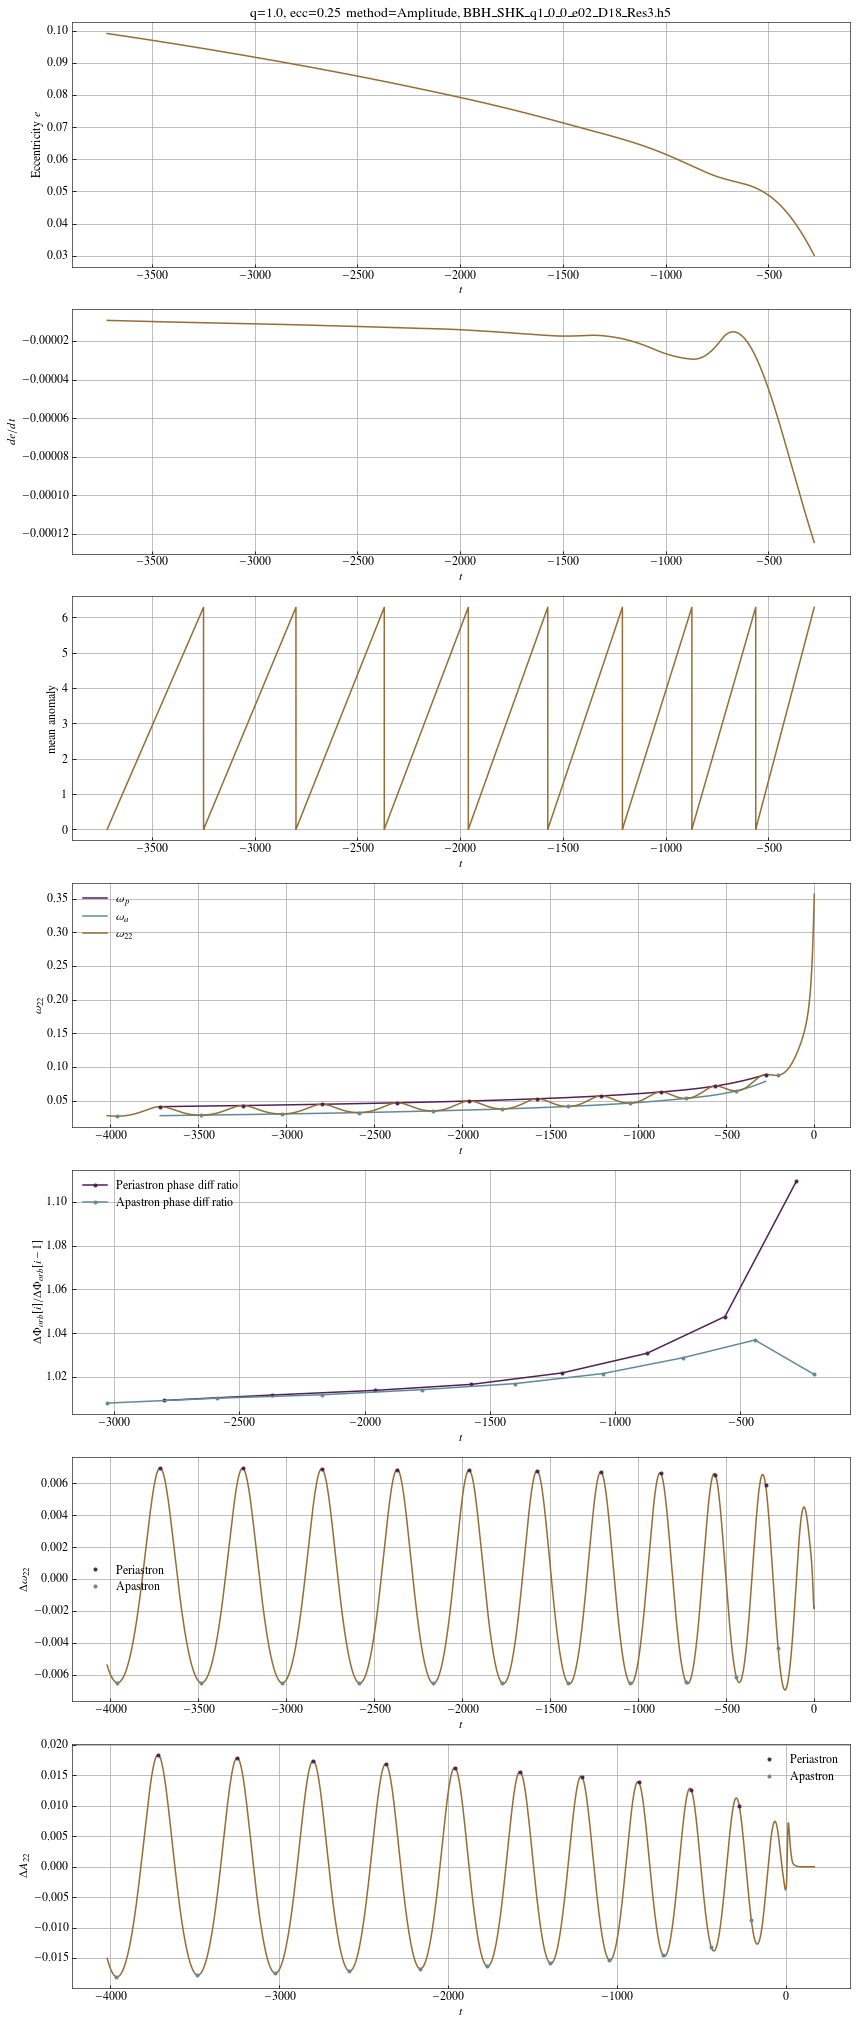

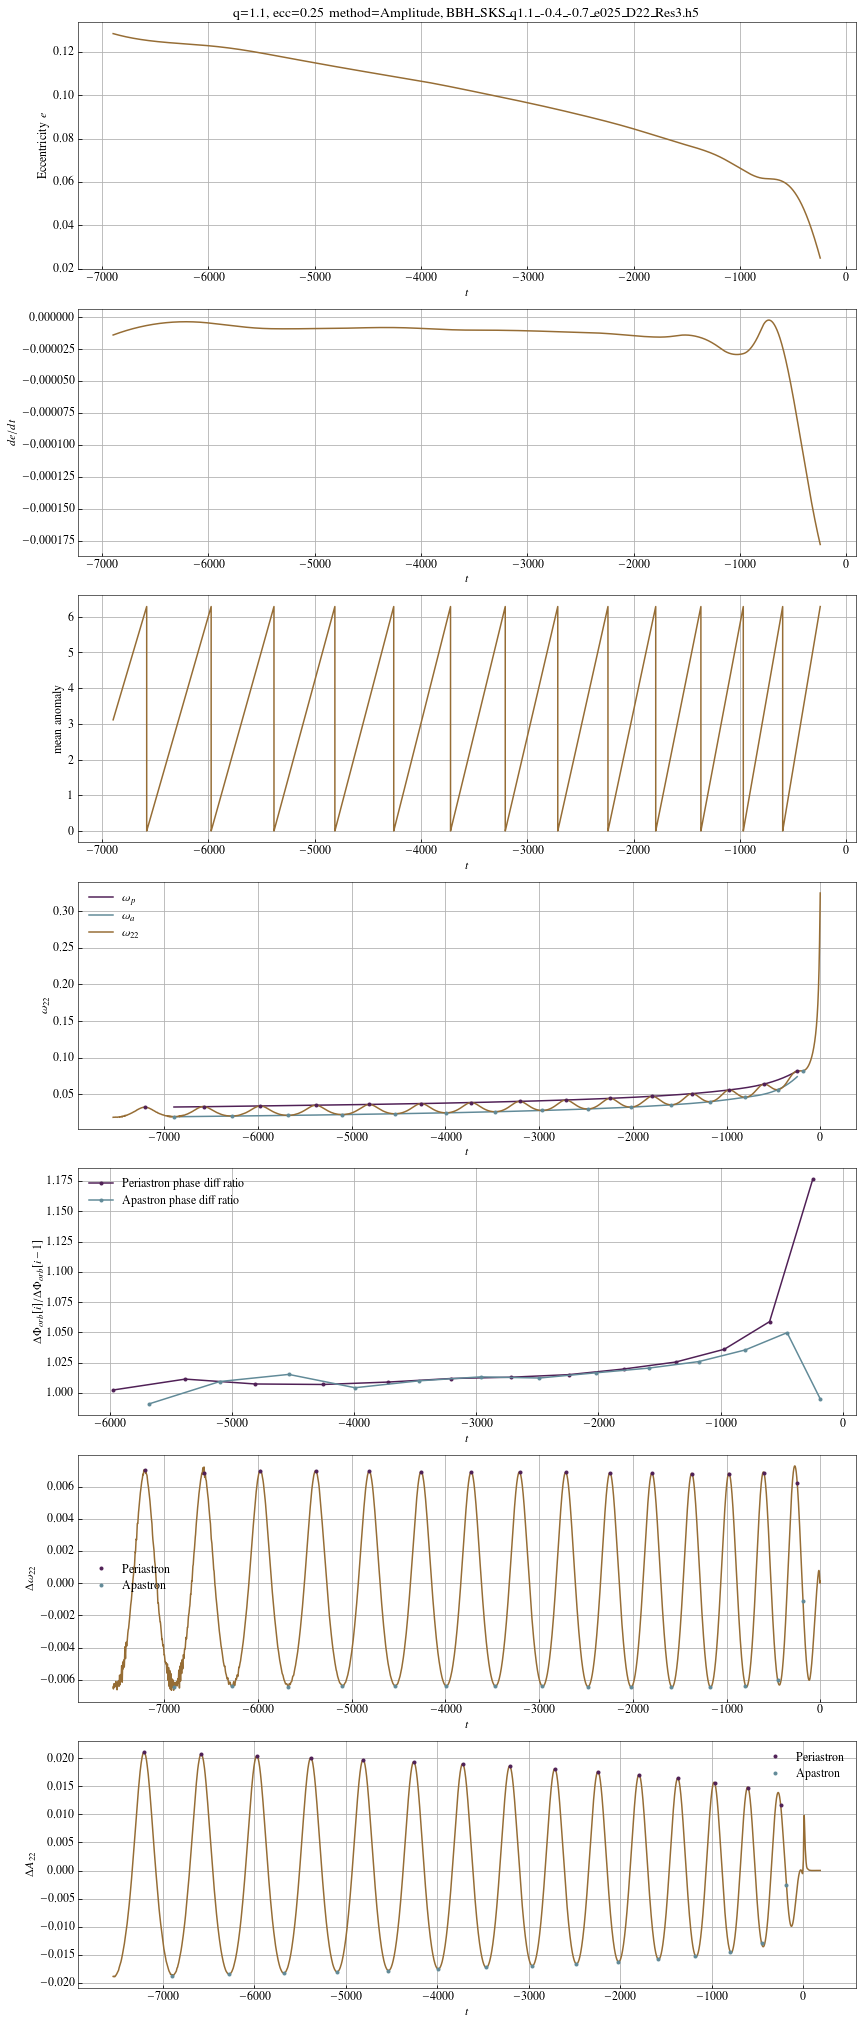

In [21]:
method = "Amplitude"
for waveform_path in nr_waveforms[0:5]:
    waveform_keywords = {"filepath": waveform_path,
                         #"include_zero_ecc": True
                        }
    dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)
    tref_vec = dataDict["t"]
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})
    fig, ax = eccMethod.make_diagnostic_plots()
    w = waveform_path.split("/")[-1]
    q = dataDict["params_dict"]["q"]
    ecc = dataDict["params_dict"]["ecc"]
    ax[0].set_title(f"q={q:.1f}, ecc={ecc:.2f} method={method}, {w}", fontsize=14)

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:436: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:436: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


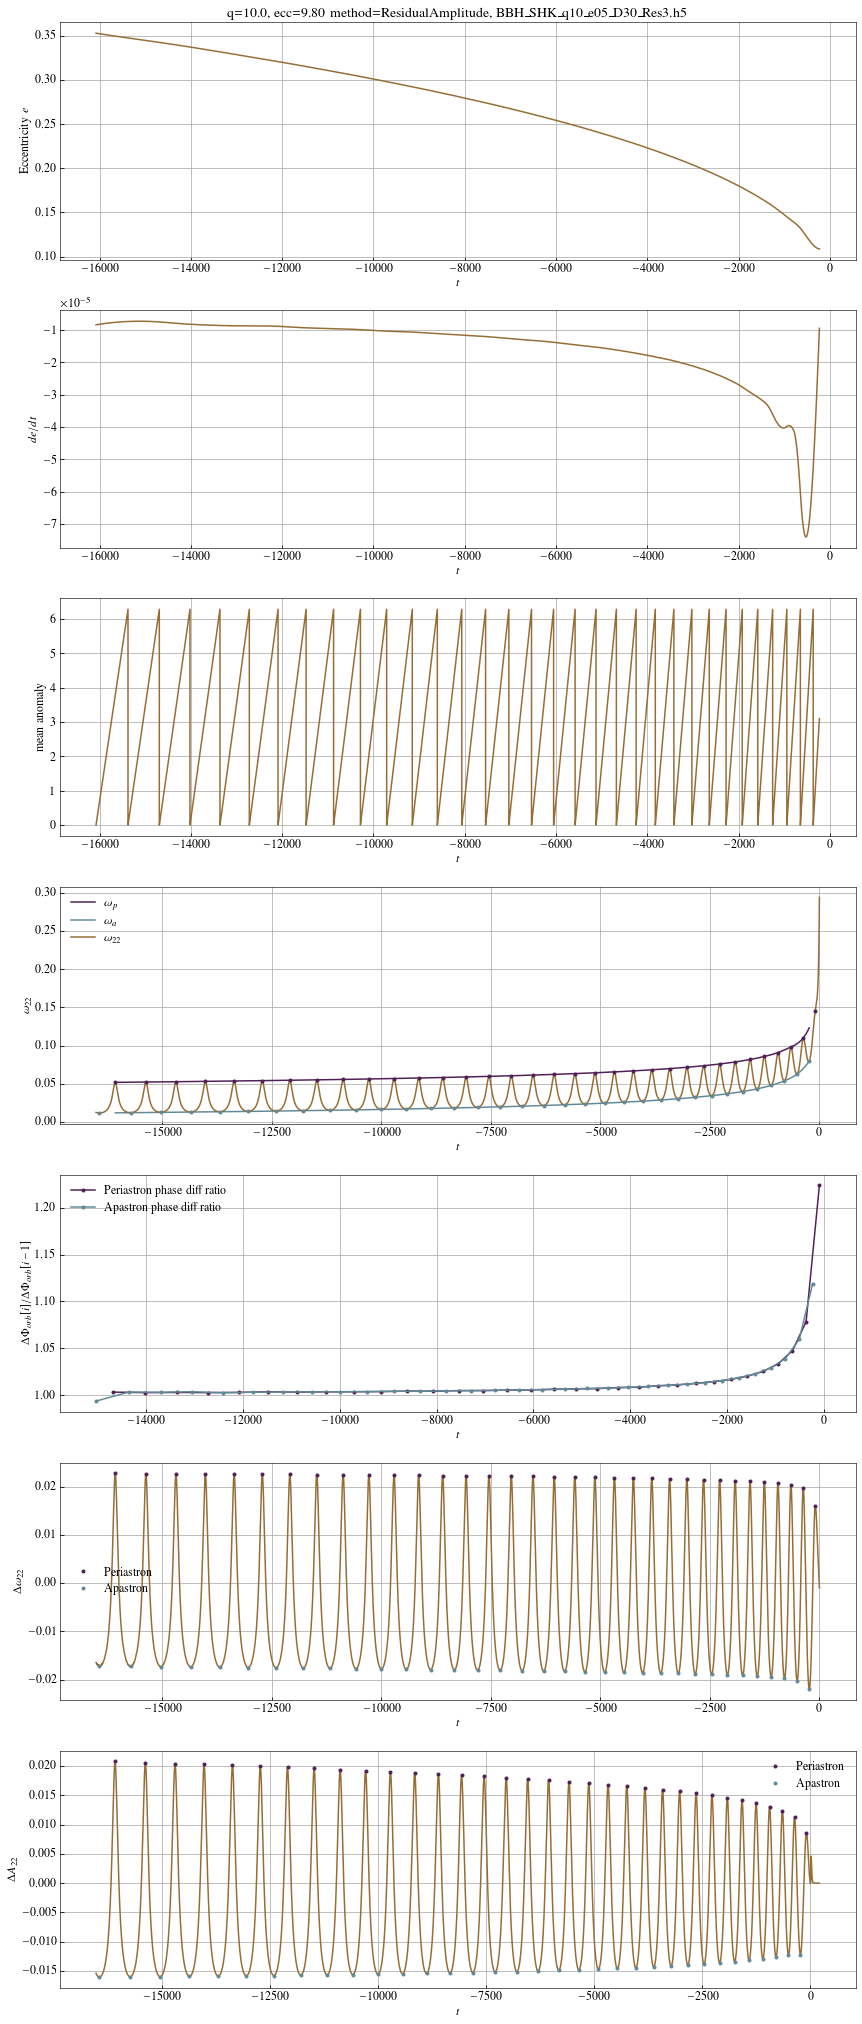

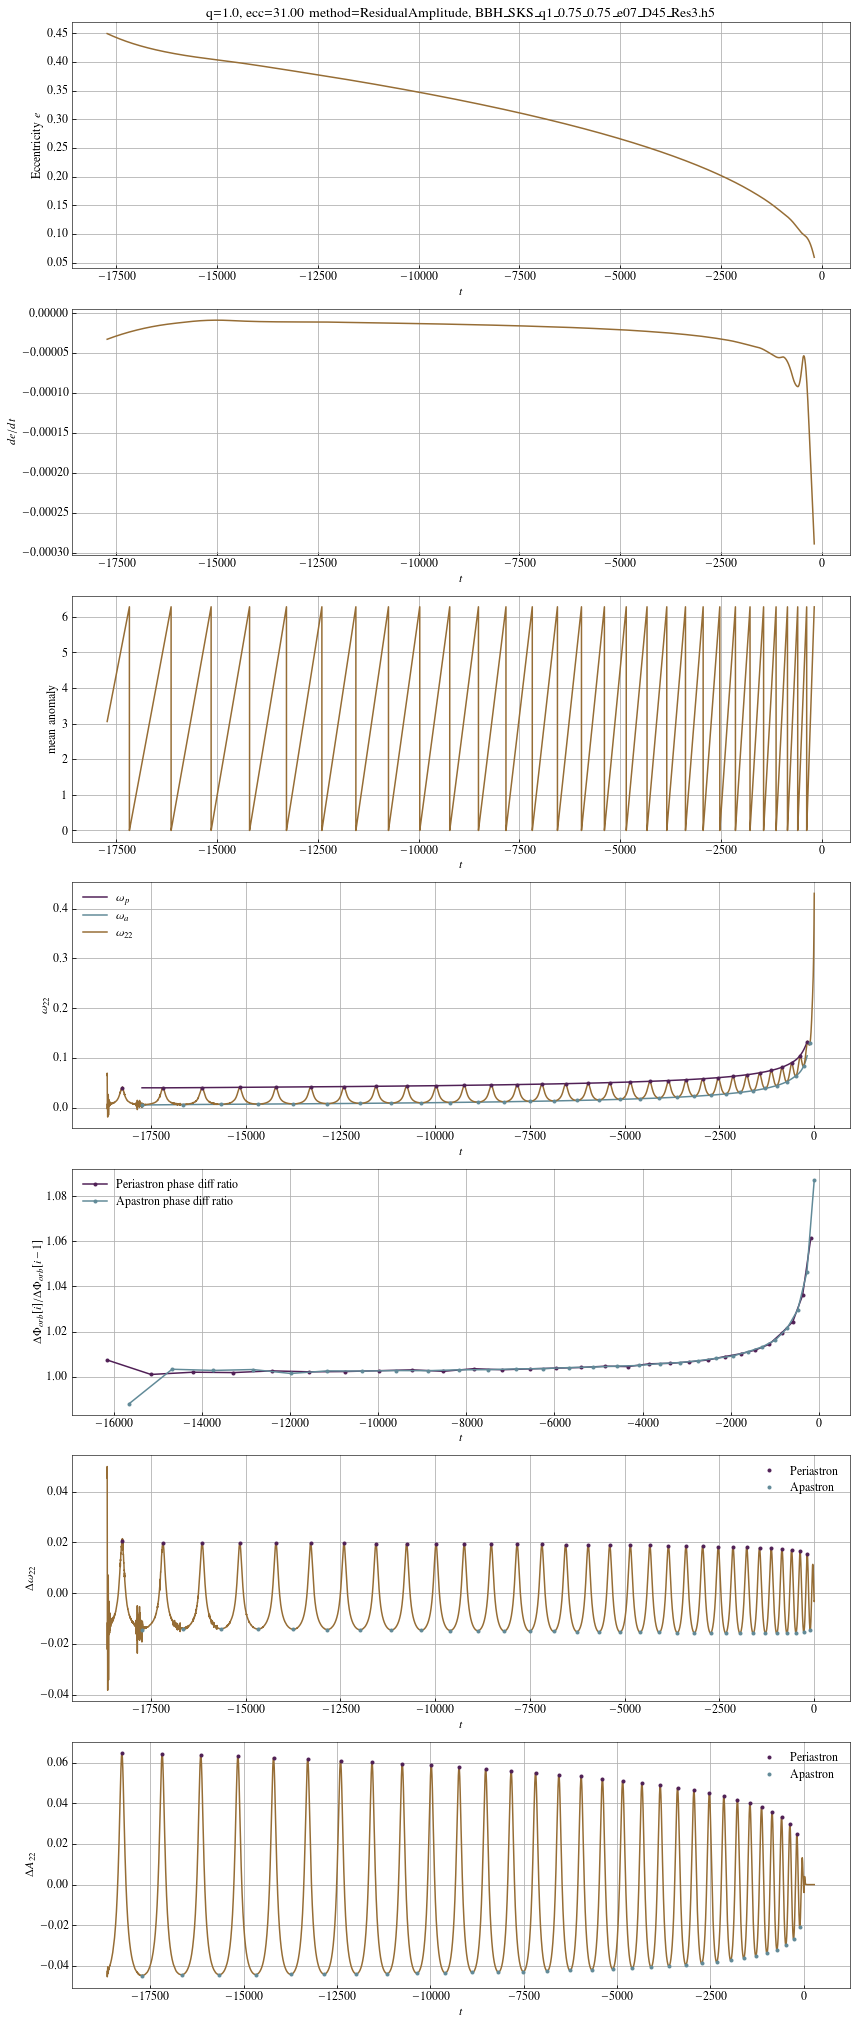

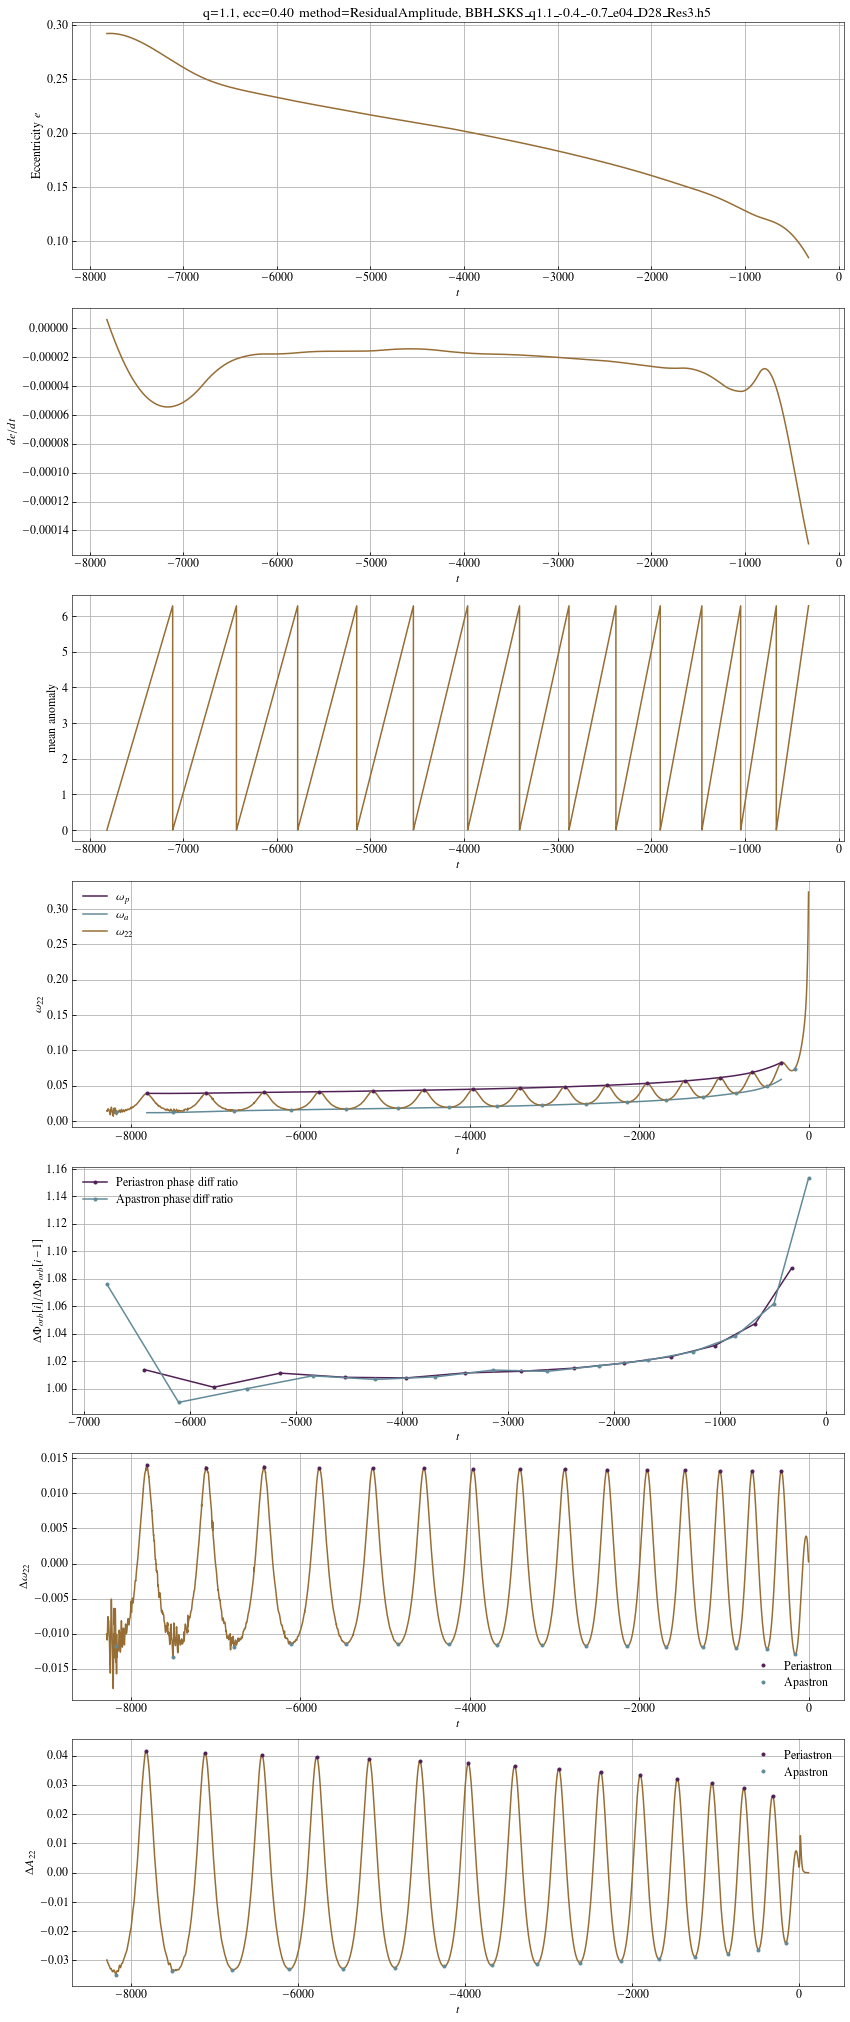

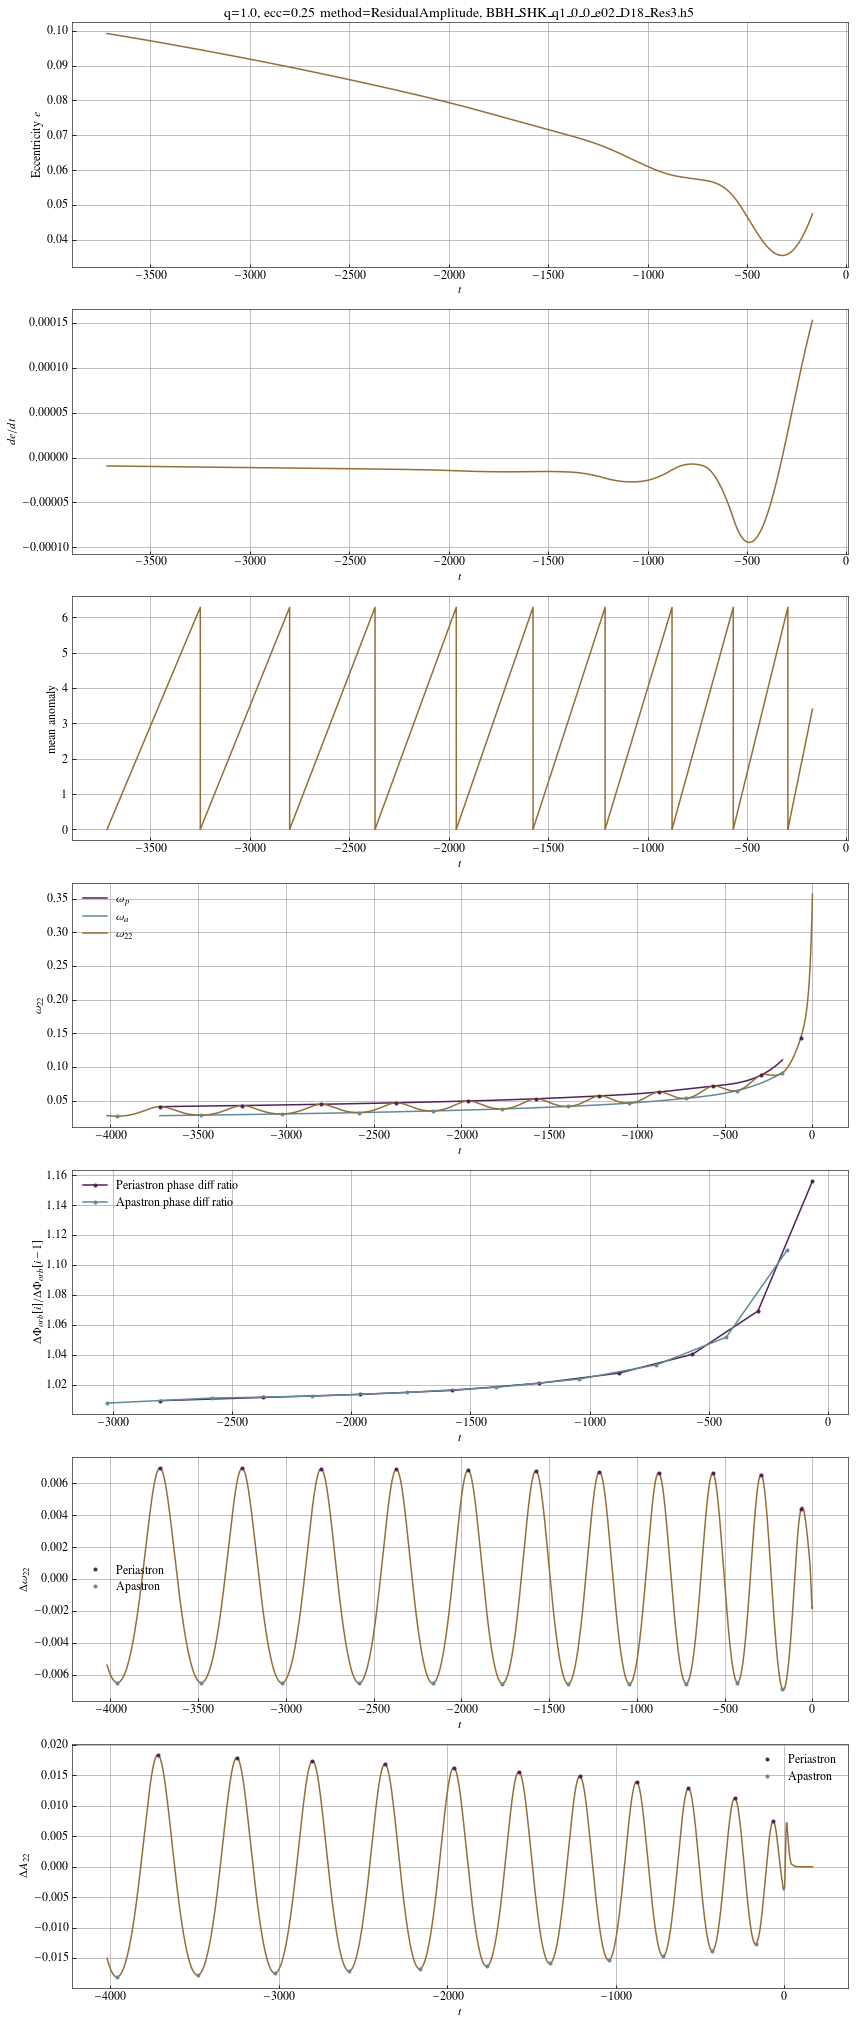

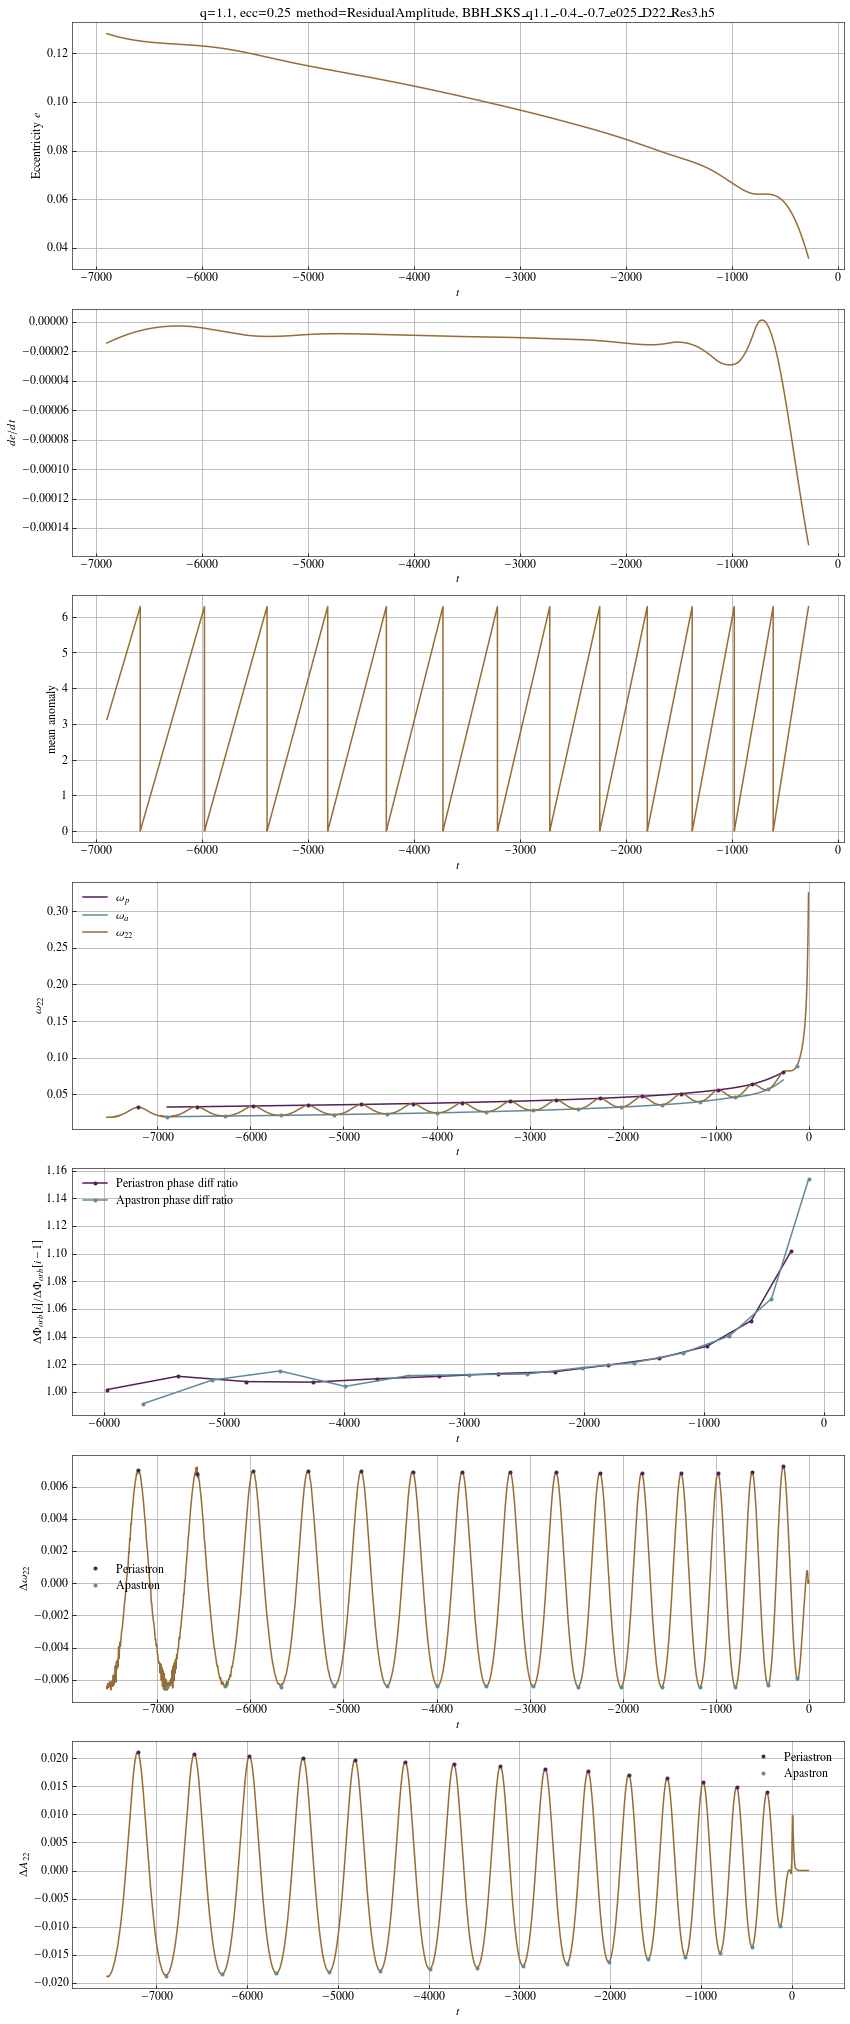

In [18]:
method = "ResidualAmplitude"
for waveform_path in nr_waveforms[0:5]:
    waveform_keywords = {"filepath": waveform_path,
                         "include_zero_ecc": True
                        }
    dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)
    tref_vec = dataDict["t"]
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})
    fig, ax = eccMethod.make_diagnostic_plots()
    w = waveform_path.split("/")[-1]
    q = dataDict["params_dict"]["q"]
    ecc = dataDict["params_dict"]["ecc"]
    ax[0].set_title(f"q={q:.1f}, ecc={ecc:.2f} method={method}, {w}", fontsize=14)